# Jantahack - Customer segmentation

An automobile company has plans to enter new markets with their existing products (P1, P2, P3, P4 and P5). After intensive market research, they’ve deduced that the behavior of new market is similar to their existing market. 

In their existing market, the sales team has classified all customers into 4 segments (A, B, C, D ). Then, they performed segmented outreach and communication for different segment of customers. This strategy has work exceptionally well for them. They plan to use the same strategy on new markets and have identified 2627 new potential customers. 

You are required to help the manager to predict the right group of the new customers.

## Data Description 

- ID	- Unique ID </br>
- Gender	- Gender of the customer
- Ever_Married	- Marital status of the customer
- Age	- Age of the customer
- Graduated	- Is the customer a graduate?
- Profession	- Profession of the customer
- Work_Experience	- Work Experience in years
- Spending_Score	- Spending score of the customer
- Family_Size	- Number of family members for the customer (including the customer)
- Var_1	- Anonymised Category for the customer
- Segmentation	(target) - Customer Segment of the customer

In [5]:
pip install catboost

     |████████████████████████████████| 65.8MB 58kB/s 


In [6]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import StratifiedKFold 
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
sns.set_style("whitegrid") # Plotting style
np.random.seed(7) # seeding random number generator

%matplotlib inline

## Data loading

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [9]:
train_raw_df = pd.read_csv('datasets/Train.csv')
test_raw_df = pd.read_csv('datasets/Test.csv')
train_raw_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [10]:
test_raw_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6


## Data Understanding

In [11]:
train_raw_df.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [12]:
### support functions ###

# get object datatype col names

def get_datatypes(df, datatype):
    '''
    Get datatypes of column names
    
    Params:
        df : dataframe
        datatype : str
    return:
        dtypes_list : list
    '''
    
    return [col for col in df.columns if df[col].dtypes== datatype]

# print unique values
def print_unique_values(df, dtypes_list):
    for col in dtypes_list:
        print('Unique values in {} column are  {} : {} \n'.format(col, df[col].ffill().nunique(), df[col].ffill().unique()))

In [13]:
print('-'*15, 'Train Dataset information', '-'*15, '\n')

# info
train_raw_df.info()
print('-'*15, 'Datatypes in data', '-'*15, '\n')

print('-'*5,'Object datatypes', '-'*5, '\n')
object_dtypes_list = get_datatypes(train_raw_df, 'O')    
print('Object type columns names are: \n', object_dtypes_list)
print_unique_values(train_raw_df, object_dtypes_list)

--------------- Train Dataset information --------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB
--------------- Datatypes in data --------------- 

----- Object datatypes ----- 

Object type columns names are: 
 ['Gender', 'Ever_Married', 'Graduated', 'Profession', '

## Data preparation

In [14]:
processed_train_df = train_raw_df.copy()
processed_train_df.isnull().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [16]:
processed_test_df = test_raw_df.copy()
processed_test_df.isnull().sum()

ID                   0
Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession          38
Work_Experience    269
Spending_Score       0
Family_Size        113
Var_1               32
dtype: int64

In [17]:
# categorical data to cardinal numbers

## fill missing values with new variable
processed_train_df['Profession'] = processed_train_df['Profession'].fillna('Unkown')
processed_train_df['Var_1'] = processed_train_df['Var_1'].fillna('Cat_8')

processed_test_df['Profession'] = processed_test_df['Profession'].fillna('Unkown')
processed_test_df['Var_1'] = processed_test_df['Var_1'].fillna('Cat_8')


## map string names to number format
processed_train_df['Gender'] = processed_train_df['Gender'].map({'Male':1,'Female':0}).astype('int32')
processed_train_df['Ever_Married'] = processed_train_df['Ever_Married'].map({'No':0,'Yes':1})
processed_train_df['Graduated'] = processed_train_df['Graduated'].map({'No':0,'Yes':1})
# processed_train_df['Profession'] = processed_train_df['Profession'].map({'Healthcare':0,'Engineer':1,'Lawyer':2,'Entertainment':3, 'Artist':4, 'Executive':5, 'Doctor':6, 'Homemaker':7, 'Marketing':8, 'Unkown':9}).astype('str')
processed_train_df['Spending_Score'] = processed_train_df['Spending_Score'].map({'Low':0,'Average':1,'High':2}).astype('int32')
# processed_train_df['Var_1'] = processed_train_df['Var_1'].map({'Cat_1':0,'Cat_2':1,'Cat_3':2,'Cat_4':3, 'Cat_5':4, 'Cat_6':5, 'Cat_7':6, 'Cat_8':7}).astype('str')
# processed_train_df['Segmentation'] = processed_train_df['Segmentation'].map({'A':0,'B':1,'C':2,'D':3})

processed_test_df['Gender'] = processed_test_df['Gender'].map({'Male':1,'Female':0}).astype('int32')
processed_test_df['Ever_Married'] = processed_test_df['Ever_Married'].map({'No':0,'Yes':1})
processed_test_df['Graduated'] = processed_test_df['Graduated'].map({'No':0,'Yes':1})
# processed_test_df['Profession'] = processed_test_df['Profession'].map({'Healthcare':0,'Engineer':1,'Lawyer':2,'Entertainment':3, 'Artist':4, 'Executive':5, 'Doctor':6, 'Homemaker':7, 'Marketing':8, 'Unkown':9}).astype('str')
processed_test_df['Spending_Score'] = processed_test_df['Spending_Score'].map({'Low':0,'Average':1,'High':2}).astype('int32')
# processed_test_df['Var_1'] = processed_test_df['Var_1'].map({'Cat_1':0,'Cat_2':1,'Cat_3':2,'Cat_4':3, 'Cat_5':4, 'Cat_6':5, 'Cat_7':6, 'Cat_8':7}).astype('str')

In [18]:
processed_train_df.describe()

,ID,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size
count,8068.000000,8068.000000,7928.000000,8068.000000,7990.000000,7239.000000,8068.000000,7733.000000
mean,463479.214551,0.547471,0.585646,43.466906,0.621777,2.641663,0.546108,2.850123
std,2595.381232,0.497772,0.492641,16.711696,0.484974,3.406763,0.741202,1.531413
min,458982.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,1.000000
25%,461240.750000,0.000000,0.000000,30.000000,0.000000,0.000000,0.000000,2.000000
50%,463472.500000,1.000000,1.000000,40.000000,1.000000,1.000000,0.000000,3.000000
75%,465744.250000,1.000000,1.000000,53.000000,1.000000,4.000000,1.000000,4.000000
max,467974.000000,1.000000,1.000000,89.000000,1.000000,14.000000,2.000000,9.000000


In [13]:
processed_test_df.describe()

,ID,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size
count,2627.000000,2627.000000,2577.000000,2627.000000,2603.000000,2358.000000,2627.000000,2514.000000
mean,463433.918919,0.542063,0.589833,43.649791,0.615444,2.552587,0.531785,2.825378
std,2618.245698,0.498322,0.491959,16.967015,0.486584,3.341094,0.736931,1.551906
min,458989.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,1.000000
25%,461162.500000,0.000000,0.000000,30.000000,0.000000,0.000000,0.000000,2.000000
50%,463379.000000,1.000000,1.000000,41.000000,1.000000,1.000000,0.000000,2.000000
75%,465696.000000,1.000000,1.000000,53.000000,1.000000,4.000000,1.000000,4.000000
max,467968.000000,1.000000,1.000000,89.000000,1.000000,14.000000,2.000000,9.000000


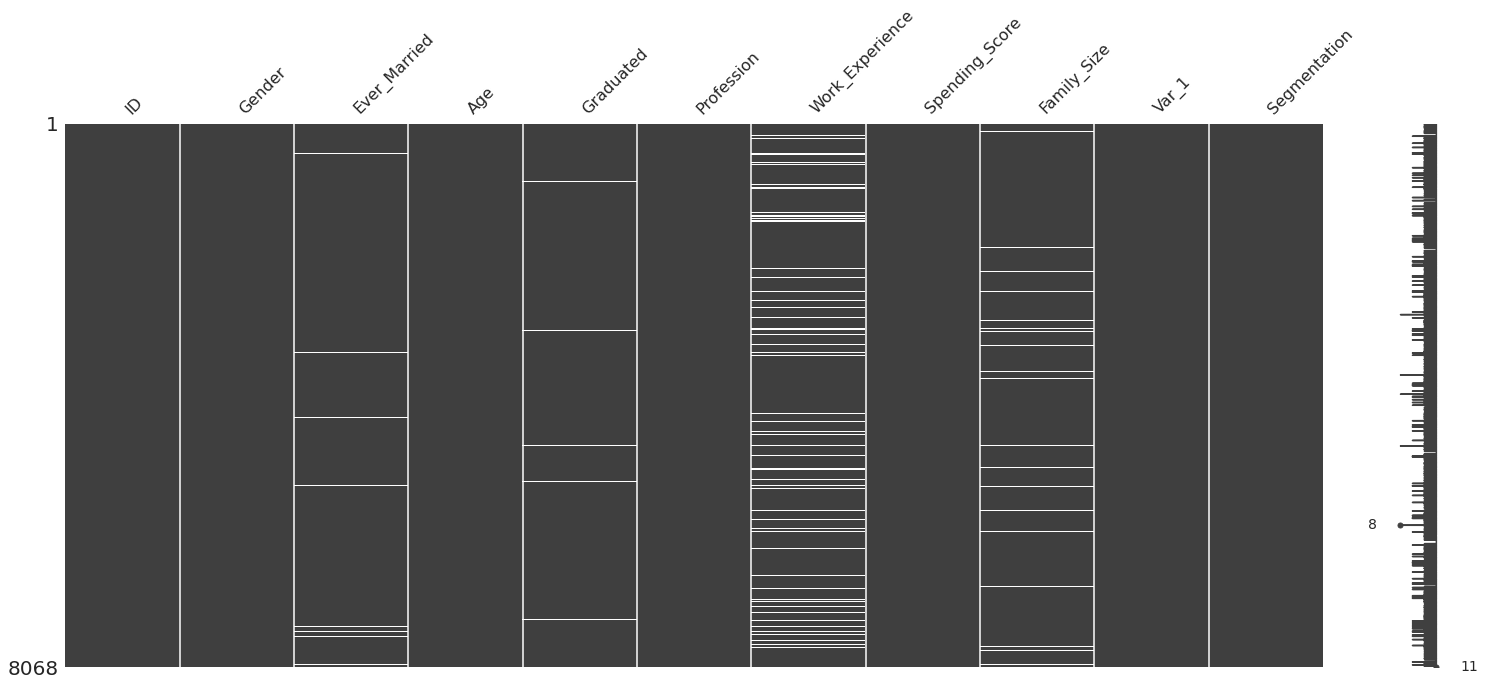

In [14]:
msno.matrix(processed_train_df);

In [19]:
train_label = processed_train_df.Segmentation
train = processed_train_df.drop(['ID', 'Segmentation'], axis=1)

In [20]:
test = processed_test_df.drop(['ID'], axis=1)

## EDA

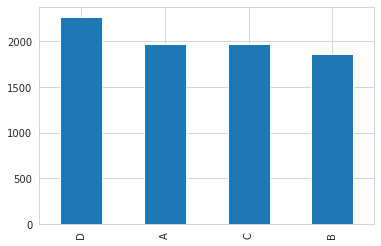

In [21]:
processed_train_df['Segmentation'].value_counts().plot(kind='bar');

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   int32  
 1   Ever_Married     7928 non-null   float64
 2   Age              8068 non-null   int64  
 3   Graduated        7990 non-null   float64
 4   Profession       8068 non-null   object 
 5   Work_Experience  7239 non-null   float64
 6   Spending_Score   8068 non-null   int32  
 7   Family_Size      7733 non-null   float64
 8   Var_1            8068 non-null   object 
dtypes: float64(4), int32(2), int64(1), object(2)
memory usage: 504.4+ KB


# Modelling

In [23]:
cat_columns = ['Profession', 'Var_1']

In [38]:
# estimators

clf_1 = xgb.XGBClassifier(n_estimators=1500,
    reg_lambda=1,
    gamma=0,
    max_depth=4)

clf_2 = LGBMClassifier(learning_rate=0.0,
                    boosting_type='gbdt', max_depth=6,  objective='multiclass', 
                    random_state=100,  
                  n_estimators=1000 ,reg_alpha=0, reg_lambda=1, n_jobs=-1, categorical_feature = 'auto')

clf_3 = CatBoostClassifier(learning_rate=0.02, n_estimators=1500, 
                          subsample=0.085, 
                          max_depth=5, 
                          verbose=500,
                          cat_features = cat_columns,
                        bootstrap_type="Bernoulli",
                          loss_function='MultiClass', 
)

In [39]:
## StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for fold, (train_index, val_index) in enumerate(skf.split(train, train_label)):

    # train set
    train_x = train.iloc[train_index]
    train_y = train_label.iloc[train_index]

    # valid set
    valid_x = train.iloc[val_index]
    valid_y = train_label.iloc[val_index]

    clf_3.fit(train_x, train_y)
    predict_y = clf_3.predict(valid_x)
    acc_score = accuracy_score(valid_y,predict_y)
    print(f"fold : {fold} , accuracy : {acc_score}")

0:	learn: 1.3778701	total: 62.3ms	remaining: 1m 33s
500:	learn: 1.0282797	total: 4.58s	remaining: 9.14s
1000:	learn: 0.9555603	total: 9.6s	remaining: 4.79s
1499:	learn: 0.9095806	total: 14.7s	remaining: 0us
fold : 0 , accuracy : 0.533457249070632
0:	learn: 1.3789395	total: 12ms	remaining: 17.9s
500:	learn: 1.0275202	total: 4.52s	remaining: 9.02s
1000:	learn: 0.9567220	total: 9.64s	remaining: 4.8s
1499:	learn: 0.9103060	total: 14.6s	remaining: 0us
fold : 1 , accuracy : 0.5390334572490706
0:	learn: 1.3793597	total: 11.8ms	remaining: 17.7s
500:	learn: 1.0342941	total: 4.6s	remaining: 9.17s
1000:	learn: 0.9666732	total: 9.43s	remaining: 4.7s
1499:	learn: 0.9198455	total: 14.3s	remaining: 0us
fold : 2 , accuracy : 0.5607187112763321
0:	learn: 1.3785847	total: 12ms	remaining: 18.1s
500:	learn: 1.0303202	total: 4.61s	remaining: 9.19s
1000:	learn: 0.9601871	total: 9.54s	remaining: 4.75s
1499:	learn: 0.9125556	total: 14.6s	remaining: 0us
fold : 3 , accuracy : 0.5375077495350279
0:	learn: 1.3788

In [40]:
# fit the best classifier
clf_3.fit(train, train_label)

0:	learn: 1.3770143	total: 15.9ms	remaining: 23.9s
500:	learn: 1.0313450	total: 5.48s	remaining: 10.9s
1000:	learn: 0.9687254	total: 11.4s	remaining: 5.69s
1499:	learn: 0.9280722	total: 17.2s	remaining: 0us


In [41]:
# predict
predict_y = clf_3.predict(test)

predict_df = pd.DataFrame(predict_y, columns = ['Segmentation'])

# concat with ID for submission
submission_df = pd.concat([predict_df, test_raw_df['ID']], axis=1)

In [42]:
# save to csv
submission_df.to_csv('catboost.csv', index=False)